In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
import datetime
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier

In [0]:
!pip install -U -q xgboost

In [0]:
from wordcloud import WordCloud, STOPWORDS
import xgboost as xgb

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#Authenticate and create the PyDrive client

auth.authenticate_user()
gauth=GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive=GoogleDrive(gauth)


     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
link ="https://drive.google.com/open?id=18yHOyLnrSgzAabvXoev4C2yjzSThegLB"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('database.sqlite')

In [6]:
# Load the data from .sqlite file

db=sqlite3.connect('database.sqlite')

# select all reviews from given dataset
# we are considering a review is positive or negative on the basis of the Score column which is nothing but a rating given
# by a customer for a product. If a score >3 it is considered as positive elseif score<3 it is negative and score=3 is neutral
# Therefore all reviews which are having score other than 3 are taken into account.

filtered_data=pd.read_sql_query("""
SELECT *
FROM Reviews WHERE Score!=3""",db)

# Replace this numbers in Score column as per our assumptions i.e replace 3+ with positive 1 and 3- with negative 0
def partition(x):
    if x < 3:
        return -1
    return 1

# changing reviews with score less than 3 to be positive (1) and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print(filtered_data.shape)

(525814, 10)


In [0]:
# converting datestamp into string representable form as YYYY-MM-DD
filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d'))

In [8]:
# There is lot of duplicate data present as we can see above productId B007OSBE1U 
# have multiple duplicate reviews this is what we need to avoid.

# so first step is to sort the data and then remove duplicate entries so that only
# one copy of them should be remain in our data.
dup_free=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})
# dup_free.head()
# This is shape of our dataset of 100k datapoints after removal of dups
dup_free.shape

(364173, 10)

In [0]:
final_filtered_data=dup_free[dup_free.HelpfulnessNumerator<=dup_free.HelpfulnessDenominator]

In [10]:
final_filtered_data.shape

(364171, 10)

In [11]:
((final_filtered_data['Id'].size*1.0)/(filtered_data['Id'].size*(1.0)))*100

69.25852107399194

#### so after data cleanup we left with 69.25% data of 525k datapoints

In [0]:
filtered_data=filtered_data.sort_values(by='Time').reset_index(drop=True)

In [13]:
final=filtered_data.sample(frac=0.13,random_state=2)
final.shape

(68356, 10)

In [14]:
print("Positive Reviews: ",final[final.Score ==1].shape[0])
print("Positive Reviews: ",final[final.Score ==-1].shape[0])

Positive Reviews:  57745
Positive Reviews:  10611


In [15]:
 import nltk
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Text Preprocessing 

In [0]:
# Now we have already done with data cleanup part. As in our dataset most cruicial or I can say most determinant feature
# from which we can say it is positive or negative review is review Text.
# So we are need to perform some Text Preprocessing on it before we actually convert it into word vector or vectorization

# I am creating some precompiled objects for our regular expressions cause it will be used for over ~64K times (in our case)
# as it seems fast but using regular expression is CPU expensive task so it would be faster to use precompiled search objects.

_wont  = re.compile(r"won't")
_cant  = re.compile(r"can\'t")
_not   = re.compile(r"n\'t")
_are   = re.compile(r"\'re")
_is    = re.compile(r"\'s")
_would = re.compile(r"\'d")
_will  = re.compile(r"\'ll")
_have  = re.compile(r"\'ve")
_am    = re.compile(r"\'m")

# we are ignoring "not" from stopwords as "not" plays important role for semantic analysis as it can alone change the 
# meaning of whole sentence
stopWords = set(stopwords.words('english'))
sw=stopWords.copy()
sw.discard('not')

def expand_abbrevated_words(phrase):
    phrase = re.sub(_wont, "will not", phrase)
    phrase = re.sub(_cant, "can not", phrase)
    phrase = re.sub(_not, " not", phrase)
    phrase = re.sub(_are, " are", phrase)
    phrase = re.sub(_is, " is", phrase)
    phrase = re.sub(_would, " would", phrase)
    phrase = re.sub(_will, " will", phrase)
    phrase = re.sub(_have, " have", phrase)
    phrase = re.sub(_am, " am", phrase)
    return phrase

# As this dataset is web scrapped from amazon.com while scrapping there might be a good chance that we are getting some garbage
# characters/words/sentences in our Text data like html tags,links, alphanumeric characters so we ought to remove them
def remove_unwanted_char(data):    
    processed_data=[]
    for sentence in tqdm(data):
        sentence = re.sub(r"http\S+", "", sentence) # this will remove links
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = re.sub("\S*\d\S*", "", sentence).strip() #remove alphanumeric words
        sentence = re.sub('[^A-Za-z]+', ' ', sentence) #remove special characters
        sentence =  expand_abbrevated_words(sentence)
        # we need to convert everything into lower case because I dont want my model to treat same word differently
        # if it appears in the begining of sentence and somewhere middle of sentence.
        # Also remove stopword froms from sentences
        sentence =" ".join(j.lower() for j in sentence.split() if j.lower() not in sw)
        processed_data.append(sentence)
    return processed_data
 
def preprocess_my_data(data):
    return remove_unwanted_char(data)
        

In [18]:
data_to_be_processed=final['Text'].values
processed_data=preprocess_my_data(data_to_be_processed)
label=final['Score']
print(len(processed_data))

100%|██████████| 68356/68356 [00:26<00:00, 2627.14it/s]

68356


In [19]:
final['CleanedText']=processed_data
print(processed_data[0])

tried several times get good coconut flavored coffee little success boyer trick great coffee good amount coconut flavor highly recommend


## Stemming

In [20]:
# Before applying BoW or Tfidf featurization techinque on our corpus we need to apply stemmming for each word in each document.
stemmed_data=processed_data.copy()
bow_stem=SnowballStemmer('english')
stemmed_reviews=[]
def stemSentence(review):
    token_words=word_tokenize(review)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(bow_stem.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

for review in tqdm(stemmed_data):
    stemmed_reviews.append(stemSentence(review))

100%|██████████| 68356/68356 [00:49<00:00, 1370.54it/s]


## Splitting Data In Train ,CV and Test Dataset

In [21]:
# To avoid data leakage we are splitting our dataset before any featurization.
x_tr, x_test, y_tr, y_test = train_test_split(stemmed_reviews, label, test_size=0.2, random_state=0)

print("Sizes of Train,test dataset after split: {0} , {1}".format(len(x_tr),len(x_test)))

Sizes of Train,test dataset after split: 54684 , 13672


## HyperParameter Tuning Using Simple Cross-Validation

In [0]:
def find_best_hypes(train_data,tr_label,boost=False):
    model=None
    depth=[1, 5, 10, 50, 100, 500, 100]
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    param_grid=dict()
    if boost:
        model = xgb.XGBClassifier()
        param_grid={'n_estimators':n_estimators,'max_depth':depth,'n_jobs':[-1],'colsample_bytree':[0.6],'Subsample':[0.6]}
    else:
        model = RandomForestClassifier()
        param_grid={'n_estimators':n_estimators,'max_depth':depth,'class_weight':['balanced']}
        
    tbs_cv = TimeSeriesSplit(n_splits=5).split(train_data)
    gsearch = GridSearchCV(estimator=model, cv=tbs_cv,
                            param_grid=param_grid, scoring = 'roc_auc',return_train_score=True)
    gsearch.fit(train_data, tr_label)
    print("Best Depth        : ",gsearch.best_estimator_.max_depth)
    print("Best n_estimators : ",gsearch.best_estimator_.n_estimators)
    print("Best AUC          : ",gsearch.best_score_)
    
    test_score=gsearch.cv_results_['mean_test_score']
    train_score=gsearch.cv_results_['mean_train_score']
    test_score=test_score.reshape(len(depth),len(n_estimators))
    train_score=train_score.reshape(len(depth),len(n_estimators))
    depth.reverse()
    
    plt.figure(1,figsize=(15,7))
    plt.subplot(121)
    y=np.array(n_estimators)
    sns.heatmap(test_score,xticklabels=y,yticklabels=depth,annot=test_score)
    plt.xlabel("No of estimators")
    plt.ylabel("depths")
    plt.title("Test Data AUC Scores")
    
    plt.subplot(122)
    sns.heatmap(train_score,xticklabels=y,yticklabels=depth,annot=train_score)
    plt.xlabel("No of estimators")
    plt.ylabel("depths")
    plt.title("Train Data AUC Scores")
    plt.show()
    return gsearch.best_estimator_.max_depth,gsearch.best_estimator_.n_estimators

In [0]:
def testing_on_test_data(train_rev,train_label,test_rev,test_label,depth,n_estimators,boost=False):
    plt.figure(1)
    model=None
    train_pred=None
    test_pred=None
    if boost:
        model = xgb.XGBClassifier(max_depth=depth,n_estimators=n_estimators,colsample_bytree=0.6,Subsample=0.6)
        model.fit(train_rev,train_label)
        train_pred = model.predict_proba(train_rev,ntree_limit=0)[:,1]
        test_pred= model.predict_proba(test_rev,ntree_limit=0)[:,1]
    else:
        model=RandomForestClassifier(max_depth=depth,n_estimators=n_estimators,class_weight='balanced')
        model.fit(train_rev,train_label)
        train_pred = model.predict_log_proba(train_rev)[:,1]
        test_pred= model.predict_log_proba(test_rev)[:,1]
        
    
    train_pred=np.nan_to_num(train_pred)
    test_pred=np.nan_to_num(test_pred)

    # Train data AUC value
    fpr_tr,tpr_tr, _ = roc_curve(train_label, train_pred)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    
    # Test data AUC value
    fpr_t,tpr_t, _ = roc_curve(test_label, test_pred)
    roc_auc_t= auc(fpr_t, tpr_t)
    
    plt.plot(fpr_tr, tpr_tr, color='darkorange',
            lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_tr)
    plt.plot(fpr_t, tpr_t, color='black',
            lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_t)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for Train and Test dataset')
    plt.legend(loc="lower right")
    plt.show()


In [0]:
def get_confusion_matrix(train_rev,train_label,test_rev,test_label,depth,n_estimators,boost=False):
    plt.figure(1,figsize=(15,7))
    np.set_printoptions(precision=5)
    model=None
    if boost:
        model = xgb.XGBClassifier(max_depth=depth,n_estimators=n_estimators,colsample_bytree=0.6,Subsample=0.6)
    else:
        model=RandomForestClassifier(max_depth=depth,n_estimators=n_estimators,class_weight='balanced')
    model.fit(train_rev,train_label)
    train_pred=model.predict(train_rev)
    test_pred=model.predict(test_rev)

    test_cnf_matrix=confusion_matrix(test_label,test_pred)
    train_cnf_matrix=confusion_matrix(train_label,train_pred)
    
    plt.subplot(121)
    sns.heatmap(test_cnf_matrix,cmap="coolwarm_r",fmt='.8g',annot=True,linewidths=0.5)
    plt.title("TestSet Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Actual class")
    
    plt.subplot(122)
    sns.heatmap(train_cnf_matrix,cmap="coolwarm_r",fmt='.8g',annot=True,linewidths=0.5)
    plt.title("TrainSet Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Actual class")
    plt.show()

In [0]:
def plot_word_cloud(top_words):
    plt.figure(1,figsize=(15,7))
    wc = WordCloud(background_color="white", max_words=len(top_words), stopwords=sw)
    wc.generate(str(top_words))
    plt.title("Word Cloud for Top Features")
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [0]:
def get_top_imp_features(train_rev,labels,vectorizer,depth,n_estimators,boost=False):
    model=None
    if boost:
        model = xgb.XGBClassifier(max_depth=depth,n_estimators=n_estimators,colsample_bytree=0.6,Subsample=0.6)
    else:
        model=RandomForestClassifier(max_depth=depth,n_estimators=n_estimators,class_weight='balanced')
    model.fit(train_rev,labels)
    #this sorts the  features probabilities return index of sorted values
    top_feat_probs=model.feature_importances_
    top_feat_probs=top_feat_probs.argsort() # sort all values in ascending order
    
    # feature_importances_ will give us probability values of each feature; higher the value more important feature is   
    top_20_feat_prob=np.take(vectorizer.get_feature_names(), top_feat_probs[-20:])
    print("Top 20 Important Features: ",top_20_feat_prob)
    
    top_20_feat_prob=top_20_feat_prob.flatten()
    plot_word_cloud(top_20_feat_prob)

# RandomForest 

## BoW (Bag of Words)

In [0]:
# Applying fit_transform to only train dataset as we are only because we want our vocabulary to be built only on train data
bow_count=CountVectorizer(min_df=10, max_features=500)
bow_fit=bow_count.fit(x_tr)
print("Some Feature names: ",bow_fit.get_feature_names()[:5])


Some Feature names:  ['abl', 'absolut', 'acid', 'actual', 'ad']


In [0]:
#extract token count out of raw text document using vocab build using train dataset
bow_train=bow_count.transform(x_tr)
bow_test=bow_count.transform(x_test)
print("Shape of transformed train text reviews",bow_train.shape)
print("Shape of transformed test text reviews",bow_test.shape)

Shape of transformed train text reviews (54684, 500)
Shape of transformed test text reviews (13672, 500)


In [0]:
# converting sparse matrix to dense matrix before doing standardization 
bow_dense_train_reviews=bow_train.toarray()
bow_dense_test_reviews=bow_test.toarray()
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()
std_train_data=std_data.fit_transform(bow_dense_train_reviews*1.0)
std_test_data=std_data.transform(bow_dense_test_reviews*1.0)

### Finding Best Hyperparameters

Best Depth        :  500
Best n_estimators :  200
Best AUC          :  0.9044023118202595


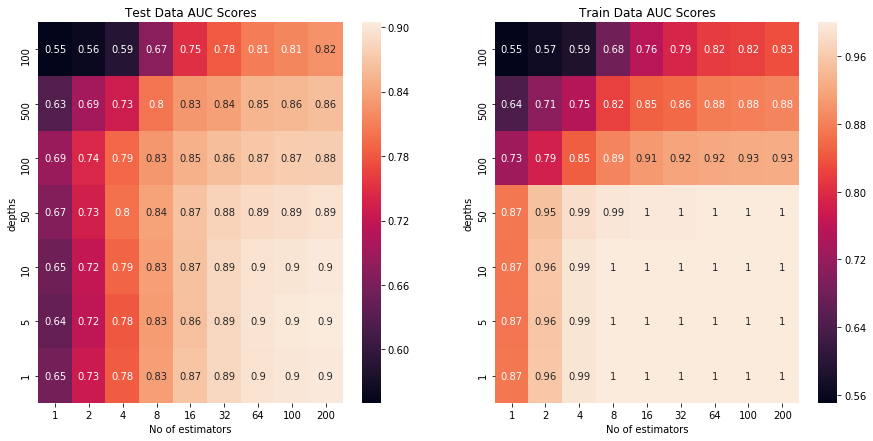

In [0]:
depth,n_estimators=find_best_hypes(std_train_data,y_tr)

In [0]:
# According to heatmap best depth and no of estimators values
depth,n_estimators=10,64

### Testing with Test Data

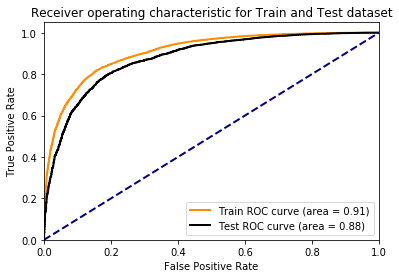

In [0]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,depth,n_estimators)

### Confusion Matrix

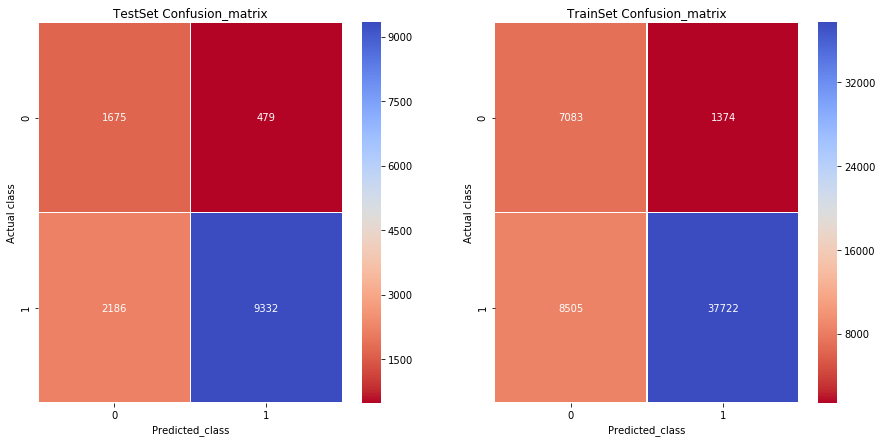

In [0]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,depth,n_estimators)

### Top 10 positive and negative features using l1 regularizer

Top 20 Important Features:  ['tast' 'snack' 'product' 'keep' 'receiv' 'would' 'review' 'easi'
 'favorit' 'money' 'thought' 'wast' 'perfect' 'bad' 'delici' 'best'
 'great' 'disappoint' 'love' 'not']


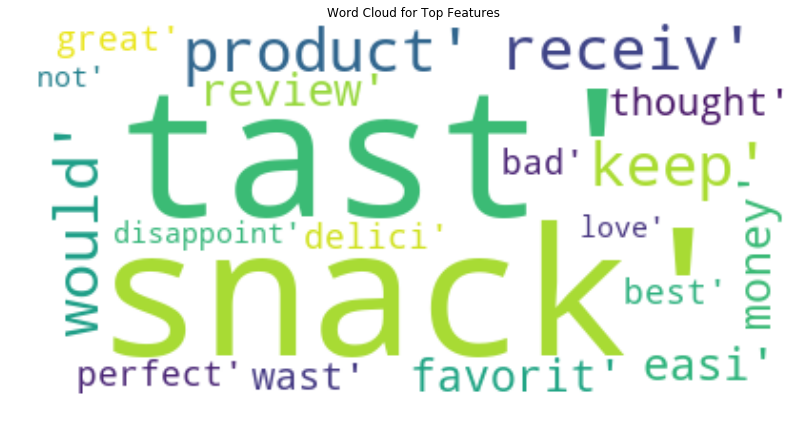

In [0]:
 get_top_imp_features(std_train_data,y_tr,bow_fit,depth,n_estimators)

## 2.TFIDF

In [0]:
tfidf_count= TfidfVectorizer(min_df=10,max_features=500,ngram_range=(1,2))
tfidf_tr=tfidf_count.fit_transform(x_tr)
tfidf_test=tfidf_count.transform(x_test)
print("Shape of tfidf vector representation of train review text :",tfidf_tr.shape)
print("Shape of tfidf vector representation of test review text  :",tfidf_test.shape)

Shape of tfidf vector representation of train review text : (54684, 500)
Shape of tfidf vector representation of test review text  : (13672, 500)


In [0]:
# converting sparse matrix to dense matrix before doing standardization 
tfidf_dense_train_reviews=tfidf_tr.toarray()
tfidf_dense_test_reviews=tfidf_test.toarray()

# Apply standardization on train,test and cv dataset
std_data=StandardScaler()

std_train_data=std_data.fit_transform(tfidf_dense_train_reviews*1.0)
std_test_data=std_data.transform(tfidf_dense_test_reviews*1.0)


### Finding Best Hyperparameters

Best Depth        :  500
Best n_estimators :  200
Best AUC          :  0.9098734419875955


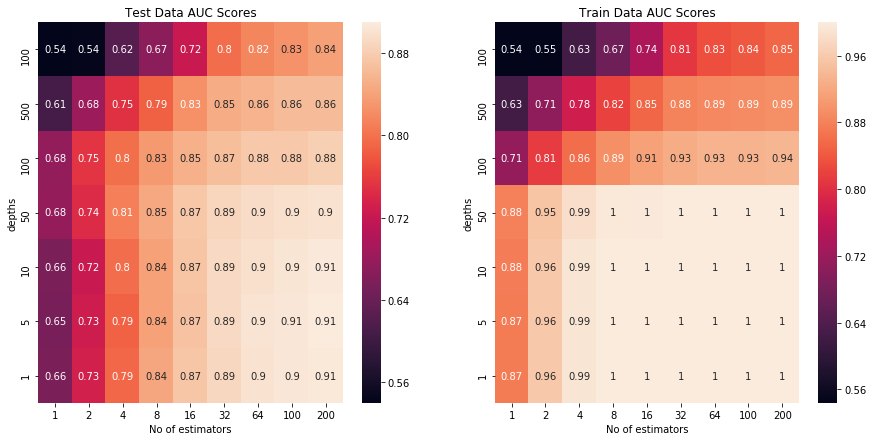

In [0]:
depth,n_estimators=find_best_hypes(std_train_data,y_tr)

In [0]:
# According to heatmap best depth and no of estimators values
depth,n_estimators=10,200

### Testing with Test Data

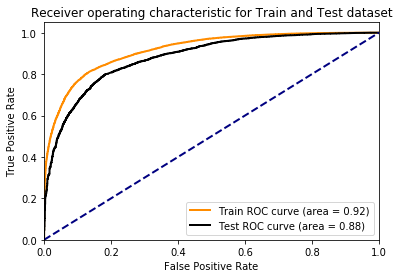

In [0]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,depth,n_estimators)

### Confusion Matrix

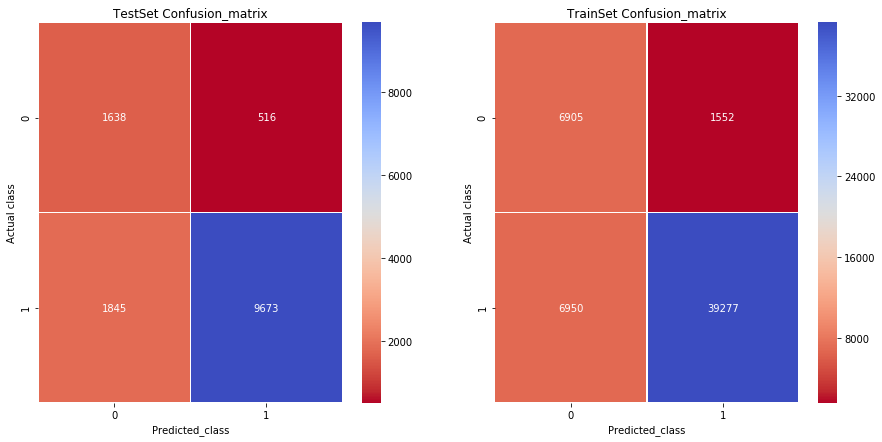

In [0]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,depth,n_estimators)

### Top 10 positive and negative features

Top 20 Important Features:  ['go' 'would' 'syrup' 'tasti' 'away' 'normal' 'easi' 'fast' 'hope' 'three'
 'morn' 'wast' 'bad' 'pick' 'delici' 'benefit' 'differ' 'machin' 'notic'
 'got']


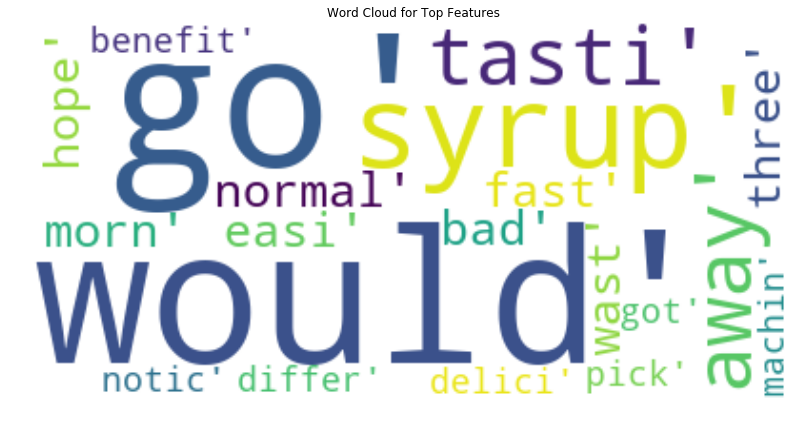

In [0]:
 get_top_imp_features(std_train_data,y_tr,bow_fit,depth,n_estimators)

## 3. Avg Word2Vec

In [0]:
# As w2vec preserves semantic meaning of words I am not going to do stemming for this.
# split each sentence from train dataset into words
reviews=x_tr.copy()
train_sentences_set=[]
for s in reviews:
    train_sentences_set.append(s.split())
# min_count = 10 considers only words that occured atleast 10 times
# size = dimensionality of word vectors
# workers = no of threads to use while training our w2v model/featurization
w2v_model=Word2Vec(train_sentences_set,min_count=10,size=300, workers=4)
w2v_words= list(w2v_model.wv.vocab)

In [0]:
def compute_avgW2Vec(reviews):
    # average Word2Vec
    # compute average word2vec for each review.
    rev_words=[]
    for i in reviews:
        rev_words.append(i.split())

    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(rev_words): # for each review/sentence
        sent_vec = np.zeros(300) # as our w2v model is trained with size=50 i.e 50 dimension so this value will be change as dim change
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    return sent_vectors #Average W2v repersentation of reviews in given dataset


In [0]:
train_avgw2v=compute_avgW2Vec(x_tr) 

100%|██████████| 54684/54684 [01:03<00:00, 860.38it/s]


In [0]:
test_avgw2v=compute_avgW2Vec(x_test) 

100%|██████████| 13672/13672 [00:16<00:00, 834.98it/s]


In [0]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()
std_train_data=std_data.fit_transform(train_avgw2v)
std_test_data=std_data.transform(test_avgw2v)

### Finding Best Hyperparameters

Best Depth        :  500
Best n_estimators :  200
Best AUC          :  0.910504120666263


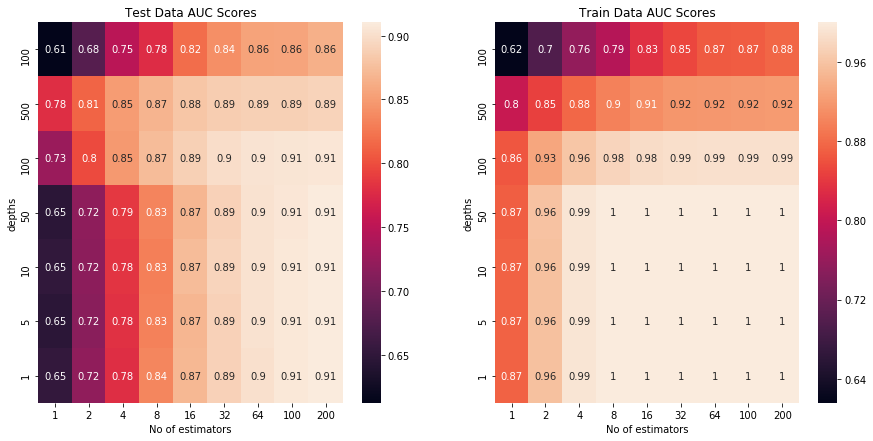

In [0]:
depth,n_estimators=find_best_hypes(std_train_data,y_tr)

In [0]:
# According to heatmap best depth and no of estimators values
depth,n_estimators=10,100

### Testing with Test Data

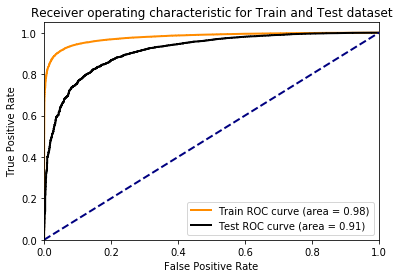

In [0]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,depth,n_estimators)

### Confusion Matrix

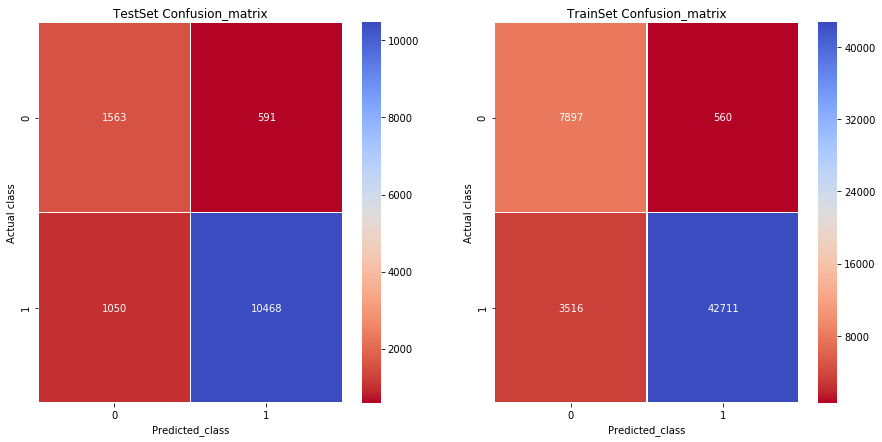

In [0]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,depth,n_estimators)

## 4. TFIDF weighted W2Vec

In [0]:
tfidf_w2v = TfidfVectorizer(min_df=10,max_features=300)
tfidf_w2v.fit(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_w2v.get_feature_names(), list(tfidf_w2v.idf_)))
tfidf_feat = tfidf_w2v.get_feature_names() # tfidf words/col-names

In [0]:
def compute_tfidf_w2vec(reviews):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0
    rev_words=[]
    for i in reviews:
        rev_words.append(i.split())

    for sent in tqdm(rev_words): # for each review/sentence 
        sent_vec = np.zeros(300) #as our w2v model is trained with size=50 i.e 500 dimension so this value will be change as dim change
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf values of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    return tfidf_sent_vectors


In [0]:
train_tfidf_w2v=compute_tfidf_w2vec(x_tr) 

100%|██████████| 54684/54684 [01:30<00:00, 606.99it/s]


In [0]:

test_tfidf_w2v=compute_tfidf_w2vec(x_test) 

100%|██████████| 13672/13672 [00:22<00:00, 605.89it/s]


In [0]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()
std_train_data=std_data.fit_transform(train_tfidf_w2v)
std_test_data=std_data.transform(test_tfidf_w2v)

### Finding Best Hyperparameters

Best Depth        :  100
Best n_estimators :  200
Best AUC          :  0.8612697365910866


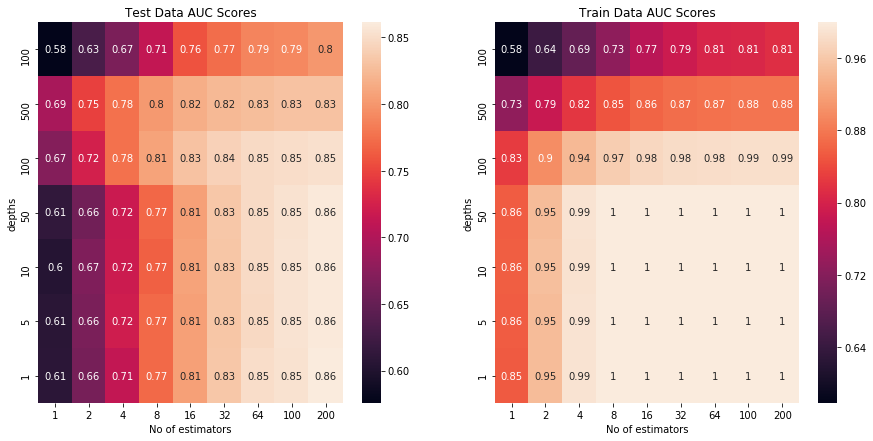

In [0]:
depth,n_estimators=find_best_hypes(std_train_data,y_tr)

In [0]:
# According to heatmap best depth and no of estimators values
depth,n_estimators=10,200

### Testing with Test Data

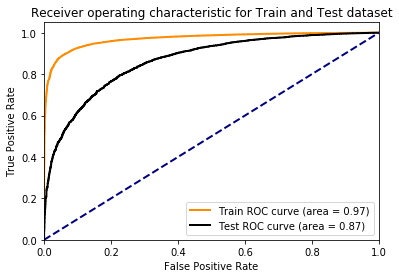

In [0]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,depth,n_estimators)

### Confusion Matrix

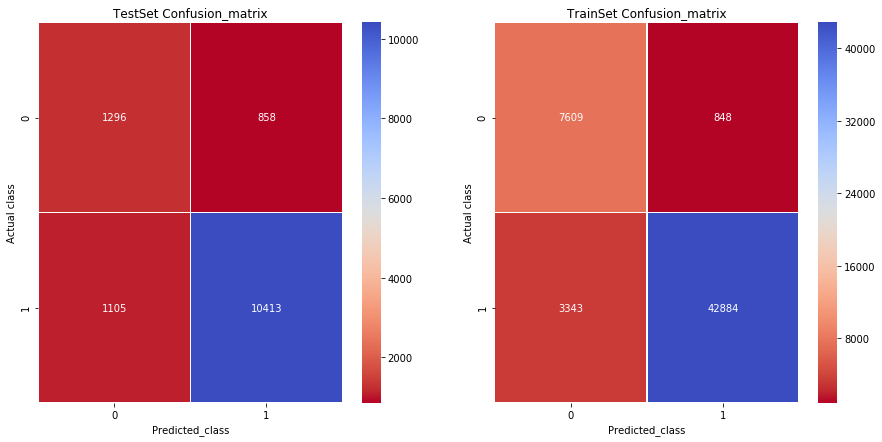

In [0]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,depth,n_estimators)

#  GBDT using XGBOOST

## BoW (Bag of Words)

In [0]:
# Applying fit_transform to only train dataset as we are only because we want our vocabulary to be built only on train data
bow_count=CountVectorizer(min_df=10, max_features=300)
bow_fit=bow_count.fit(x_tr)
print("Some Feature names: ",bow_fit.get_feature_names()[:5])


Some Feature names:  ['abl', 'absolut', 'actual', 'ad', 'add']


In [0]:
#extract token count out of raw text document using vocab build using train dataset
bow_train=bow_count.transform(x_tr)
bow_test=bow_count.transform(x_test)
print("Shape of transformed train text reviews",bow_train.shape)
print("Shape of transformed test text reviews",bow_test.shape)

Shape of transformed train text reviews (54684, 300)
Shape of transformed test text reviews (13672, 300)


### Finding Best Hyperparameters

Best Depth        :  500
Best n_estimators :  200
Best AUC          :  0.9069917093094056


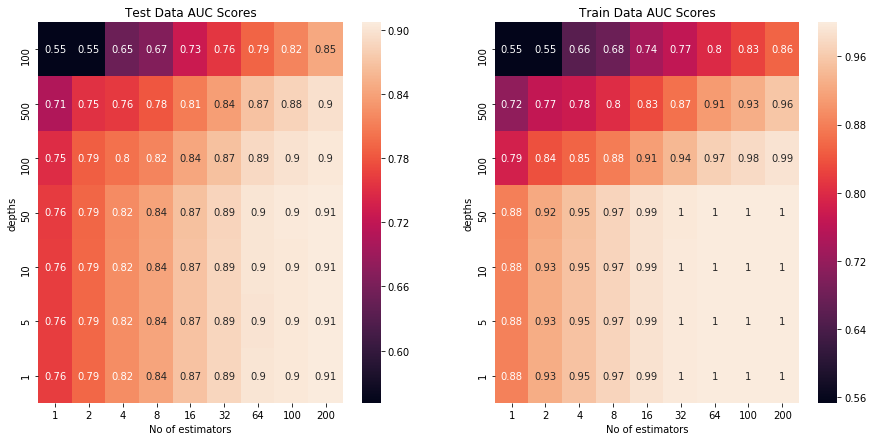

In [0]:
depth,n_estimators=find_best_hypes(bow_train,y_tr,boost=True)

In [0]:
# According to heatmap best depth and no of estimators values
depth,n_estimators=10,200

### Testing with Test Data

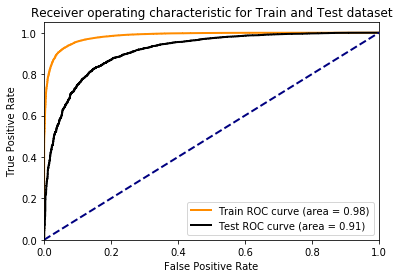

In [0]:
testing_on_test_data(bow_train,y_tr,bow_test,y_test,depth,n_estimators,boost=True)

### Confusion Matrix

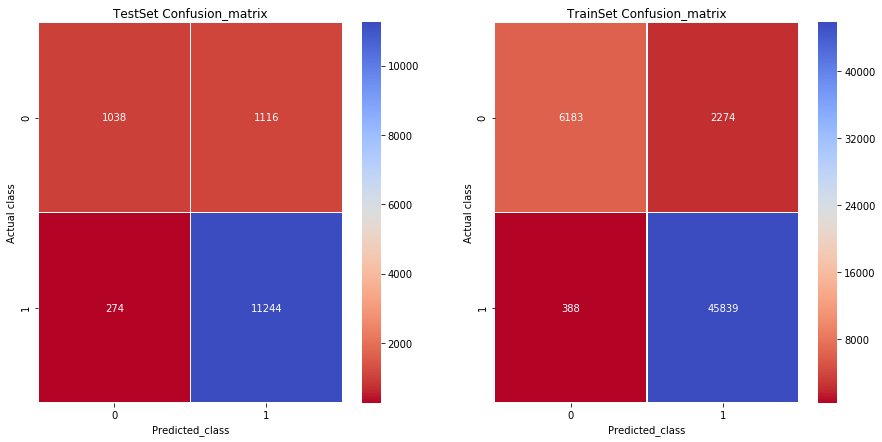

In [0]:
get_confusion_matrix(bow_train,y_tr,bow_test,y_test,depth,n_estimators,boost=True)

### Top 10 positive and negative features using l1 regularizer

Top 20 Important Features:  ['rich' 'carri' 'love' 'happi' 'wonder' 'thank' 'money' 'keep' 'smooth'
 'amaz' 'easi' 'tasti' 'great' 'favorit' 'nice' 'excel' 'disappoint'
 'best' 'delici' 'perfect']


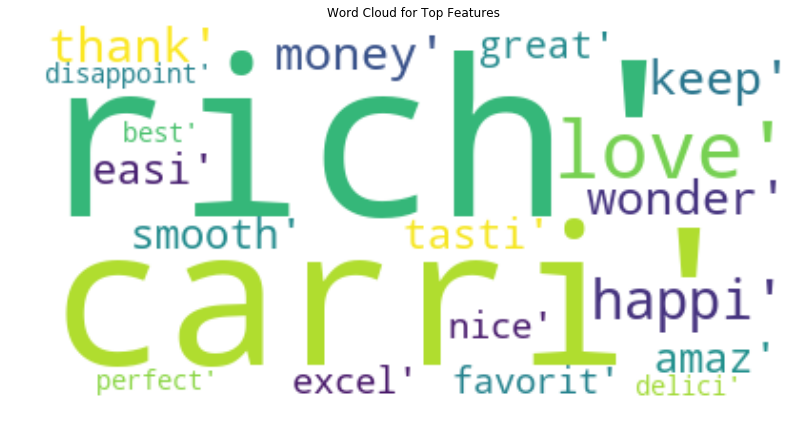

In [0]:
 get_top_imp_features(bow_train,y_tr,bow_fit,depth,n_estimators,boost=True)

## 2.TFIDF

In [0]:
tfidf_count= TfidfVectorizer(min_df=10,max_features=300,ngram_range=(1,2))
tfidf_tr=tfidf_count.fit_transform(x_tr)
tfidf_test=tfidf_count.transform(x_test)
print("Shape of tfidf vector representation of train review text :",tfidf_tr.shape)
print("Shape of tfidf vector representation of test review text  :",tfidf_test.shape)

Shape of tfidf vector representation of train review text : (54684, 300)
Shape of tfidf vector representation of test review text  : (13672, 300)


### Finding Best Hyperparameters

Best Depth        :  500
Best n_estimators :  200
Best AUC          :  0.906054356378452


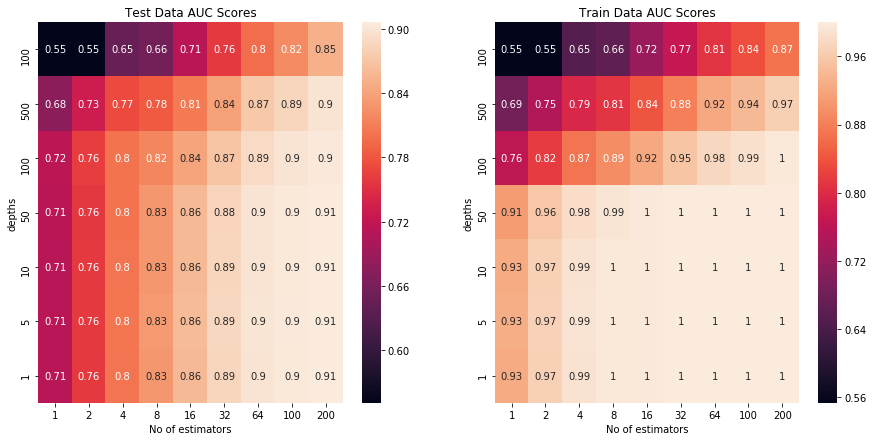

In [0]:
depth,n_estimators=find_best_hypes(tfidf_tr,y_tr,boost=True)

In [0]:
# According to heatmap best depth and no of estimators values
depth,n_estimators=10,200

### Testing with Test Data

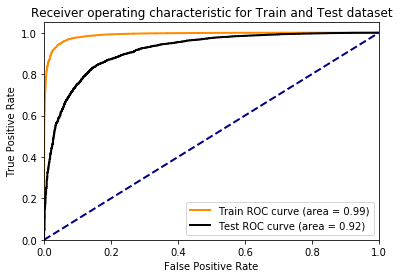

In [0]:
testing_on_test_data(tfidf_tr,y_tr,tfidf_test,y_test,depth,n_estimators,boost=True)

### Confusion Matrix

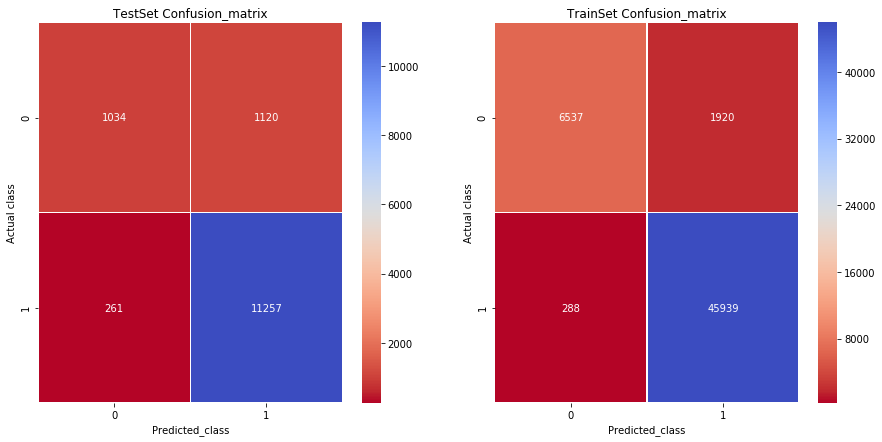

In [0]:
get_confusion_matrix(tfidf_tr,y_tr,tfidf_test,y_test,depth,n_estimators,boost=True)

### Top 10 positive and negative features

Top 20 Important Features:  ['wonder' 'snack' 'thank' 'love' 'smooth' 'bad' 'amaz' 'money' 'easi'
 'keep' 'nice' 'excel' 'great' 'tasti' 'favorit' 'best' 'perfect' 'delici'
 'disappoint' 'high recommend']


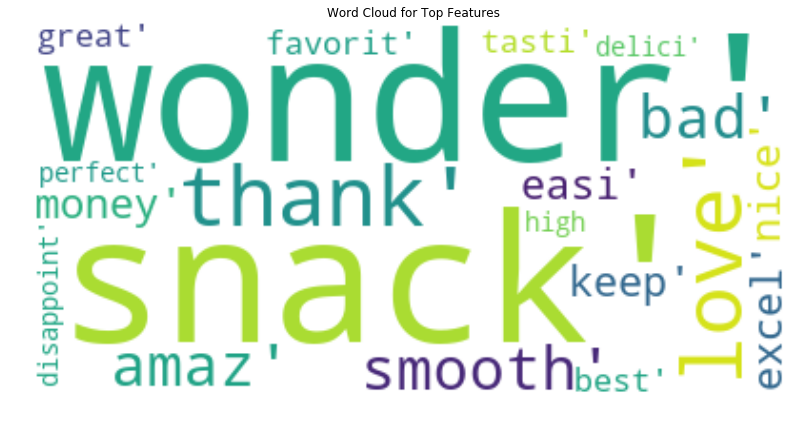

In [0]:
 get_top_imp_features(tfidf_tr,y_tr,tfidf_count,depth,n_estimators,boost=True)

## 3. Avg Word2Vec

In [0]:
# As w2vec preserves semantic meaning of words I am not going to do stemming for this.
# split each sentence from train dataset into words
reviews=x_tr.copy()
train_sentences_set=[]
for s in reviews:
    train_sentences_set.append(s.split())
# min_count = 10 considers only words that occured atleast 10 times
# size = dimensionality of word vectors
# workers = no of threads to use while training our w2v model/featurization
w2v_model=Word2Vec(train_sentences_set,min_count=10,size=300, workers=4)
w2v_words= list(w2v_model.wv.vocab)

In [0]:
def compute_avgW2Vec(reviews):
    # average Word2Vec
    # compute average word2vec for each review.
    rev_words=[]
    for i in reviews:
        rev_words.append(i.split())

    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(rev_words): # for each review/sentence
        sent_vec = np.zeros(300) # as our w2v model is trained with size=50 i.e 50 dimension so this value will be change as dim change
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    return sent_vectors #Average W2v repersentation of reviews in given dataset


In [0]:
train_avgw2v=compute_avgW2Vec(x_tr) 

100%|██████████| 54684/54684 [01:02<00:00, 870.60it/s]


In [0]:
test_avgw2v=compute_avgW2Vec(x_test) 

100%|██████████| 13672/13672 [00:15<00:00, 863.61it/s]


In [0]:
tr=np.array(train_avgw2v)
test=np.array(test_avgw2v)

### Finding Best Hyperparameters

Best Depth        :  50
Best n_estimators :  200
Best AUC          :  0.9258263330893501


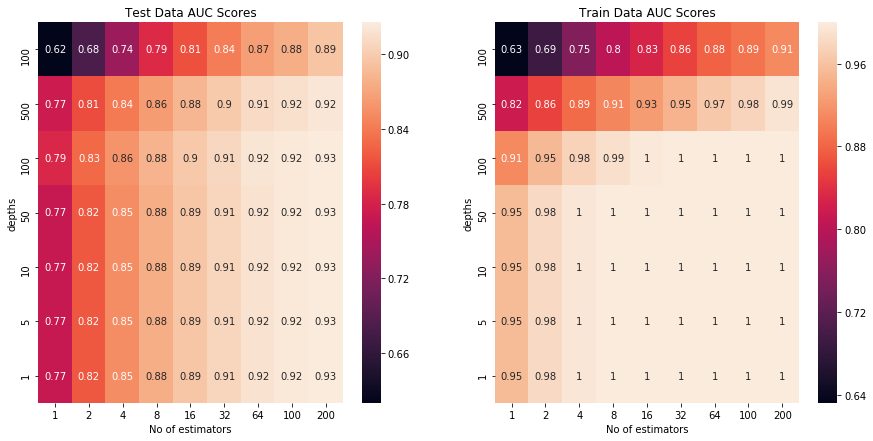

In [0]:
depth,n_estimators=find_best_hypes(tr,y_tr,boost=True)

### Testing with Test Data

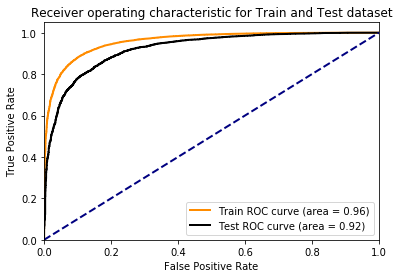

In [0]:
testing_on_test_data(tr,y_tr,test,y_test,5,100,boost=True)

### Confusion Matrix

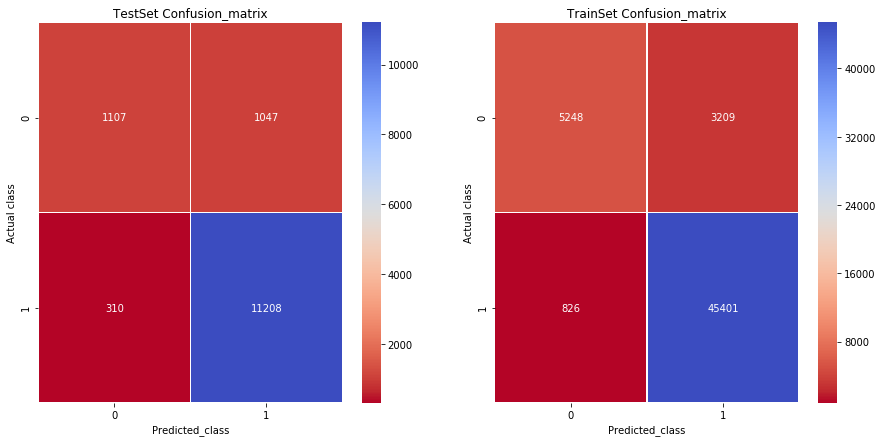

In [0]:
get_confusion_matrix(tr,y_tr,test,y_test,5,100,boost=True)

## 4. TFIDF weighted W2Vec

In [0]:
tfidf_w2v = TfidfVectorizer(min_df=10,max_features=300)
tfidf_w2v.fit(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_w2v.get_feature_names(), list(tfidf_w2v.idf_)))
tfidf_feat = tfidf_w2v.get_feature_names() # tfidf words/col-names

In [0]:
def compute_tfidf_w2vec(reviews):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0
    rev_words=[]
    for i in reviews:
        rev_words.append(i.split())

    for sent in tqdm(rev_words): # for each review/sentence 
        sent_vec = np.zeros(300) #as our w2v model is trained with size=50 i.e 500 dimension so this value will be change as dim change
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf values of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    return tfidf_sent_vectors


In [30]:
train_tfidf_w2v=compute_tfidf_w2vec(x_tr) 

100%|██████████| 54684/54684 [01:04<00:00, 841.45it/s]


In [31]:

test_tfidf_w2v=compute_tfidf_w2vec(x_test) 

100%|██████████| 13672/13672 [00:16<00:00, 824.22it/s]


In [0]:
tr=np.array(train_tfidf_w2v)
test=np.array(test_tfidf_w2v)

### Finding Best Hyperparameters

Best Depth        :  10
Best n_estimators :  200
Best AUC          :  0.8813624318829851


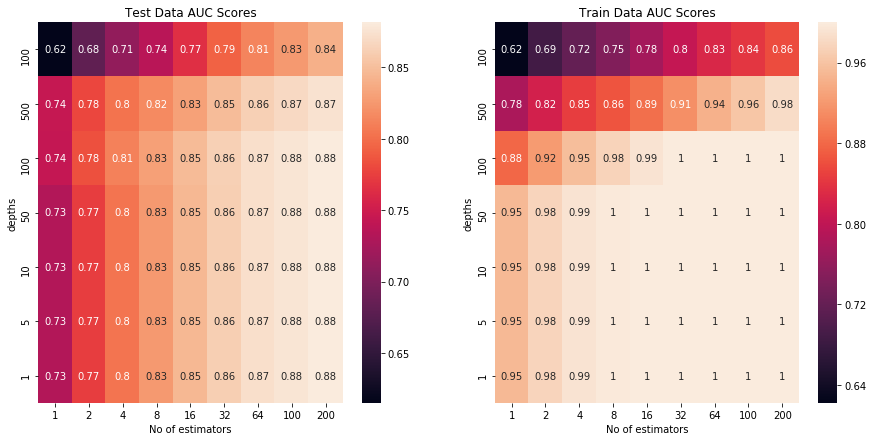

In [0]:
depth,n_estimators=find_best_hypes(tr,y_tr,boost=True)

### Testing with Test Data

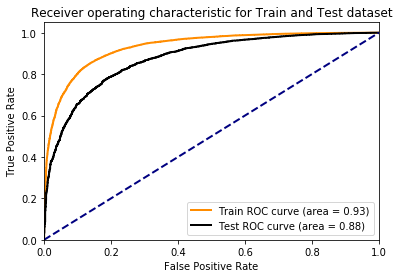

In [34]:
testing_on_test_data(tr,y_tr,test,y_test,5,100,boost=True)

### Confusion Matrix

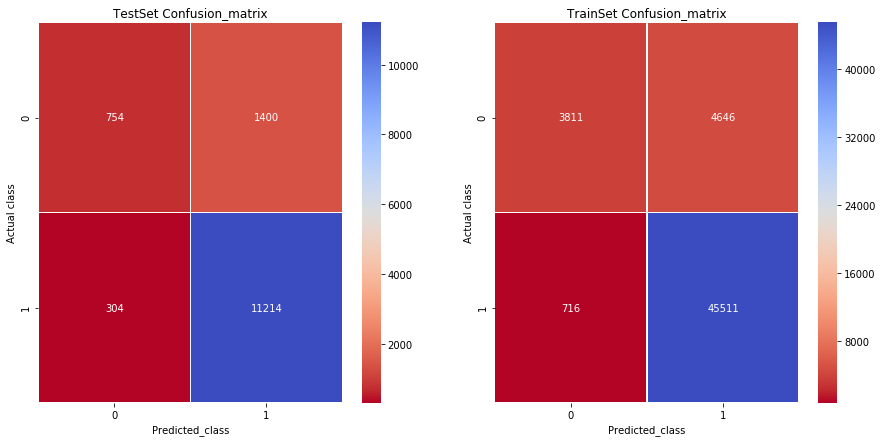

In [36]:
get_confusion_matrix(tr,y_tr,test,y_test,5,100,boost=True)

# Summary

In [37]:
print("""
+++++++++++++++++++++++++++++++++++++++ Random Forest ++++++++++++++++++++++++++++++++++++++++++++++++++++++
          |  Vectorizer    |    max_depth           |   no of estimators   |         AUC         |
          ________________________________________________________________________________________

              BoW          |      10                |      64              |  0.9044023118202595 |              
              
            tfidf          |      10                |      200             |  0.9098734419875955 |            
            
         Avg tfidf         |      10                |      100             |  0.910504120666263  |
         
     tfidf Weighted W2v    |      10                |      200             |  0.8612697365910866 |

+++++++++++++++++++++++++++++++++++++++++ XGBOOST +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

          |  Vectorizer    |      max_depth         |   no of estimators   |         AUC         |
          ________________________________________________________________________________________

            tfidf          |      10                |      200             |  0.9069917093094056 |            
              
            tfidf          |      10                |      200             |  0.906054356378452  |            
            
         Avg tfidf         |      5                 |      100             |  0.9258263330893501 |         
         
   tfidf Weighted W2v      |      5                 |      100             |  0.8813624318829851 |         
             """) 


+++++++++++++++++++++++++++++++++++++++ Random Forest ++++++++++++++++++++++++++++++++++++++++++++++++++++++
          |  Vectorizer    |    max_depth           |   no of estimators   |         AUC         |
          ________________________________________________________________________________________

              BoW          |      10                |      64              |  0.9044023118202595 |              
              
            tfidf          |      10                |      200             |  0.9098734419875955 |            
            
         Avg tfidf         |      10                |      100             |  0.910504120666263  |
         
     tfidf Weighted W2v    |      10                |      200             |  0.8612697365910866 |

+++++++++++++++++++++++++++++++++++++++++ XGBOOST +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

          |  Vectorizer    |      max_depth         |   no of estimators   |         AUC         |
          __________

# Conclusion

1. When multiple machine learning models are grouped together to perform better is known as Enssemble Models.

2. They are 4 techniques by which we can achieve this:

    *   Bagging
    *   Boosting
    *   Cascading
    *   Stacking

3. RandomForest is bagging algorithm which uses multiple Decision Trees to perform.

4. All the base estimators are overfitted i.e high variance and low bias.

5. RandomForest uses bootstrapping and can be combined with colum sampling to achieve overall best fit model.

6. In case of classification problem, final output of RandomForest will be decided on majority vote and in case of Regression problem it will be decided on Mean/Median of predictions made by all base estimators.

7. XGBoost is library to make boosting perform faster.